In [35]:
#####Joint_hierarchical_structured_topic_model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
from scipy.special import psi as psi

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    return z_id

In [3]:
####データの生成####
##データの設定
#データのパラメータ
types = 2
k = 15
d = 5000 
s = np.random.poisson(4.5, d); s[s < 2] = 2
n = np.sum(s)
v1 = 1000
v2 = 500
a = 500

#文書idと単語頻度を生成
s_id = np.repeat(np.arange(d), s)
s_list = [i for i in range(d)]
for i in range(d):
    s_list[i] = np.array(np.where(s_id==i)[0], dtype="int")
w21 = np.random.poisson(np.random.gamma(20.0, 1/0.75, n))
w22 = np.random.poisson(np.random.gamma(10.0, 1/0.75, n))
w11 = np.array([np.sum(w21[s_list[i]]) for i in range(d)])
w12 = np.array([np.sum(w22[s_list[i]]) for i in range(d)])
f1 = np.sum(w11)
f2 = np.sum(w12)

#補助文書idを生成
x = np.random.poisson(12.5, d); x[x < 2] = 2
x_id = np.repeat(np.arange(d), x)
g = np.sum(x)

In [4]:
##単語idとインデックスの設定
#単語idを設定
d_id11 = np.repeat(np.arange(d), w11)
d_id12 = np.repeat(np.arange(d), w12)
d_id21 = np.repeat(np.arange(n), w21)
d_id22 = np.repeat(np.arange(n), w22)

#インデックスを作成
d_list11 = [i for i in range(d)]; d_dt11 = [i for i in range(d)]
d_list12 = [i for i in range(d)]; d_dt12 = [i for i in range(d)]
d_list21 = [i for i in range(n)]; d_dt21 = [i for i in range(n)]
d_list22 = [i for i in range(n)]; d_dt22 = [i for i in range(n)]
for i in range(d):
    d_list11[i] = np.array(np.where(d_id11==i)[0], dtype="int")
    d_list12[i] = np.array(np.where(d_id12==i)[0], dtype="int")
    d_dt11[i] = np.repeat(1, w11[i])
    d_dt12[i] = np.repeat(1, w12[i])
for i in range(n):
    d_list21[i] = np.array(np.where(d_id21==i)[0], dtype="int")
    d_list22[i] = np.array(np.where(d_id22==i)[0], dtype="int")
    d_dt21[i] = np.repeat(1, w21[i])
    d_dt22[i] = np.repeat(1, w22[i])
    
#タグidを設定
a_id = np.repeat(np.arange(d), x)
a_list = [i for i in range(d)]
a_dt = [i for i in range(d)]
for i in range(d):
    a_list[i] = np.array(np.where(a_id==i), dtype="int")
    a_dt[i] = np.repeat(1, x[i])

In [5]:
####応答変数を生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータを生成
    #トピック分布のパラメータを生成
    weights = 3.0
    theta = np.random.dirichlet(np.repeat(0.2, k), d)
    theta1 = np.array([np.random.dirichlet(weights*theta[s_id[i], ], 1).reshape(-1) for i in range(n)])
    theta2 = np.array([np.random.dirichlet(weights*theta[s_id[i], ], 1).reshape(-1) for i in range(n)])

    #単語分布のパラメータを生成
    phi1 = np.random.dirichlet(np.repeat(0.05, v1), k)
    phi2 = np.random.dirichlet(np.repeat(0.05, v2), k)
    omega = np.random.dirichlet(np.repeat(0.1, a), k)

    #出現確率が低い単語を入れ替える
    index = np.where(np.max(phi1, axis=0) <= (k*k)/f1)[0]
    for j in range(index.shape[0]):
        phi1[np.argmax(np.random.multinomial(1, np.repeat(1/k, k), 1)), index[j]] = (k*k)/f1
    index = np.where(np.max(phi2, axis=0) <= (k*k)/f2)[0]
    for j in range(index.shape[0]):
        phi2[np.argmax(np.random.multinomial(1, np.repeat(1/k, k), 1)), index[j]] = (k*k)/f2

    ##トピックから単語を生成
    #多項分布からトピックを生成
    Z1 = np.array(rmnom(theta1[d_id21, ], f1, k, np.arange(f1), 1)[1].todense(), dtype="int8")
    Z2 = np.array(rmnom(theta2[d_id22, ], f2, k, np.arange(f2), 1)[1].todense(), dtype="int8")
    z_vec1 = np.dot(Z1, np.arange(k))
    z_vec2 = np.dot(Z2, np.arange(k))

    #トピックから単語を生成
    word_data1 = np.zeros((f1, v1), dtype="int8")
    word_data2 = np.zeros((f2, v2), dtype="int8")
    word1 = np.repeat(0, f1)
    word2 = np.repeat(0, f2)
    for i in range(n):
        out1 = rmnom(phi1[z_vec1[d_list21[i]], ], w21[i], v1, np.arange(w21[i]), 1)
        out2 = rmnom(phi2[z_vec2[d_list22[i]], ], w22[i], v2, np.arange(w22[i]), 1)
        word_data1[d_list21[i], ] = np.array(out1[1].todense(), dtype="int8")
        word_data2[d_list22[i], ] = np.array(out2[1].todense(), dtype="int8")
        word1[d_list21[i]] = np.array(out1[0], dtype="int")
        word2[d_list22[i]] = np.array(out2[0], dtype="int")

    ##トピックからタグを生成
    #多項分布からトピックを生成
    gamma = np.array([np.sum(Z1[d_list11[i], ], axis=0) / w11[i] for i in range(d)])
    S = np.array(rmnom(gamma[a_id, ], g, k, np.arange(g), 1)[1].todense(), dtype="int8")
    s_vec = np.dot(S, np.arange(k))

    #トピックからタグを生成
    out = rmnom(omega[s_vec, ], g, a, np.arange(g), 1)
    tag_data = np.array(out[1].todense(), dtype="int8")
    tag = np.array(out[0], dtype="int")

    #break条件
    freq1 = np.min(np.sum(word_data1, axis=0)) 
    freq2 = np.min(np.sum(word_data2, axis=0)) 
    freq3 = np.min(np.sum(tag_data, axis=0)) 
    if (freq1 > 0) & (freq2 > 0) & (freq3 > 0):
        break

1
2
3
4
5
6
7
8
9
10
11
12


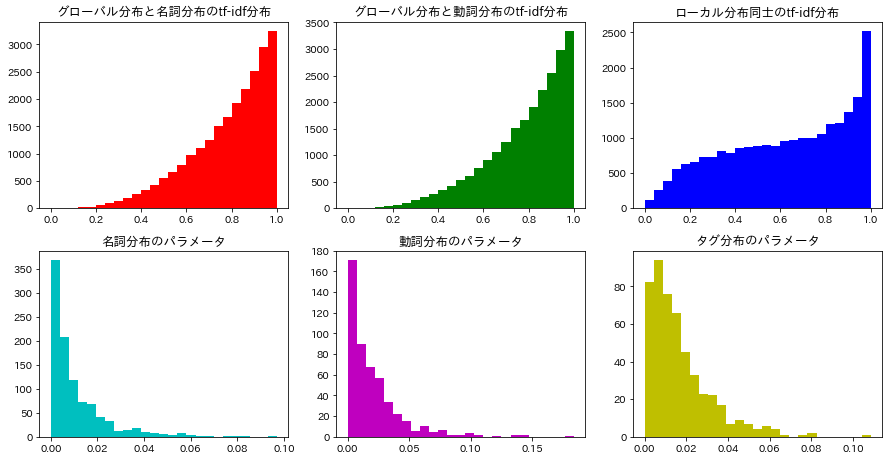

19988

In [15]:
##トピック分布間の関連性と単語分布の可視化
#トピック分布間のtf-idfを計算
normalize1 = np.sqrt(np.sum(np.power(theta[s_id, ], 2), axis=1)) * np.sqrt(np.sum(np.power(theta1, 2), axis=1))
inner_prod1 = np.sum(theta[s_id, ] * theta1, axis=1)
tf_idf1 = inner_prod1 / normalize1
normalize2 = np.sqrt(np.sum(np.power(theta[s_id, ], 2), axis=1)) * np.sqrt(np.sum(np.power(theta2, 2), axis=1))
inner_prod2 = np.sum(theta[s_id, ] * theta2, axis=1)
tf_idf2 = inner_prod2 / normalize2
normalize3 = np.sqrt(np.sum(np.power(theta1, 2), axis=1)) * np.sqrt(np.sum(np.power(theta2, 2), axis=1))
inner_prod3 = np.sum(theta1 * theta2, axis=1)
tf_idf3 = inner_prod3 / normalize3
del normalize1; normalize2; normalize3, inner_prod1, inner_prod2, inner_prod3

#tf-idfと単語分布を可視化
dt = [tf_idf1, tf_idf2, tf_idf3, np.max(phi1, axis=0), np.max(phi2, axis=0), np.max(omega, axis=0)]
fig_range = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, np.max(phi1), np.max(phi2), np.max(omega)]])
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["グローバル分布と名詞分布のtf-idf分布", "グローバル分布と動詞分布のtf-idf分布", 
          "ローカル分布同士のtf-idf分布", "名詞分布のパラメータ", "動詞分布のパラメータ", "タグ分布のパラメータ"]
fig = plt.figure(figsize=(12.5, 6.5))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()
gc.collect()

In [21]:
####マルコフ連鎖モンテカルロ法でパラメータをサンプリング#####
#トピック尤度と負担率を計算する関数
def LLho(theta, phi, d_id, wd, f, k):
    Lho = theta[d_id, ] * (phi.T)[wd, ]
    topic_rate = Lho / np.sum(Lho, axis=1)[:, np.newaxis]
    return Lho, topic_rate

In [22]:
##アルゴリズムの設定
R = 2000   #サンプリング回数
keep = 2   #2回に1回の割合でサンプリング結果を格納
disp = 10
iter = 0
burnin = int(500/keep)

In [370]:
i = 0
alpha1 = np.repeat(1.5, k)
index1 = d_list21[i]
q = 10
z1 = np.sum(Z1[index1, ], axis=0)
z1 = np.sum(np.random.multinomial(1, theta1[i, ], q), axis=0)

In [371]:
new_alpha = alpha1 * (psi(theta[d_id11[i], ] + alpha1) - psi(alpha1)) / (psi(q+np.sum(alpha1)) - psi(np.sum(alpha1)))
print(new_alpha)
print(np.sum(new_alpha))

[1.29576865e-08 1.74878158e-01 7.49607197e-10 3.10568744e-04
 2.07632246e-03 9.94555034e-05 4.63455784e-01 7.98861312e-01
 5.60732053e-04 2.81631353e-03 7.72962361e-01 4.17464414e-01
 1.34994966e-02 3.30106358e-09 8.05119922e-01]
3.4521048559583813


In [372]:
new_alpha

array([1.29576865e-08, 1.74878158e-01, 7.49607197e-10, 3.10568744e-04,
       2.07632246e-03, 9.94555034e-05, 4.63455784e-01, 7.98861312e-01,
       5.60732053e-04, 2.81631353e-03, 7.72962361e-01, 4.17464414e-01,
       1.34994966e-02, 3.30106358e-09, 8.05119922e-01])

In [373]:
theta[d_id11[i], ]

array([3.46210316e-09, 4.77073152e-02, 2.00284042e-10, 8.29824480e-05,
       5.54899245e-04, 2.65733591e-05, 1.30903237e-01, 2.35091403e-01,
       1.49829299e-04, 7.52728575e-04, 2.26744463e-01, 1.17257641e-01,
       3.61264050e-03, 8.81995542e-10, 2.37116283e-01])

In [224]:
np.sum(psi(z1+alpha1) - k*psi(alpha1)) / (psi(q+alpha1*k) - k*psi(alpha1*k))

-3.4288760398400675

In [159]:
delta1 = np.sum((psi(z1+(alpha1*theta[d_id11[i],])) - psi(alpha1*theta[d_id11[i], ])))
delta2 = psi(q+alpha1) - psi(alpha1)
delta1 / delta2

-5.289039896592189

In [233]:
np.sum(psi(z1+alpha1)) - k*psi(alpha1)

5.366666666666666

In [241]:
np.sum(psi(z1+alpha1) - psi(alpha1)) / (psi(q+alpha1) - psi(alpha1))

1.8322720498577425

In [237]:
psi(alpha1*k)

2.6743466616607936